In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### IMPORT DATA

In [175]:
df_riders = pd.read_csv('data/Riders.csv')
df_sample_submission = pd.read_csv('data/SampleSubmission.csv')
df_test = pd.read_csv('data/Test.csv')
df_train = pd.read_csv('data/Train.csv')
df_variable_definitions = pd.read_csv('data/VariableDefinitions.csv')

### UTILITY FUNCTIONS

In [79]:
import math

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def convert_dt(df,cols):
    for i in cols:
        df[i] = pd.to_datetime(df[i])
    return df

def time_of_day(df,cols):
    for col in cols:
        df = df.assign(
                    col=pd.cut(
                        df[col].dt.hour,
                        [0, 6, 12, 18, 24],
                        labels=["Night", "Morning", "Afternoon", "Evening"],
                    )
                )
    return df

def f(x):
    if (x > 0) and (x <= 6):
        return 'Night'
    elif (x > 6) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 18):
        return'Noon'
    elif (x > 18) and (x <= 24):
        return 'Eve'
    
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_test), y_test),
                m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

### COMBINE TRAINING AND TEST

In [80]:
disjoint_cols = ['Arrival at Destination - Time',
 'Arrival at Destination - Weekday (Mo = 1)',
 'Arrival at Destination - Day of Month']

In [81]:
df_train_new = df_train.drop(disjoint_cols,axis=1) 

In [82]:
df_train_new["col_type"] = 'train'
df_test["col_type"] = 'test'

In [83]:
df = pd.concat([df_train_new, df_test], ignore_index=True,sort=True);

In [84]:
df = df.merge(df_riders,how='left',on='Rider Id')

In [165]:
df.columns

Index(['Arrival at Pickup - Day of Month', 'Arrival at Pickup - Time',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Confirmation - Day of Month',
       'Confirmation - Time', 'Confirmation - Weekday (Mo = 1)',
       'Destination Lat', 'Destination Long', 'Distance (KM)', 'Order No',
       'Personal or Business', 'Pickup - Day of Month', 'Pickup - Time',
       'Pickup - Weekday (Mo = 1)', 'Pickup Lat', 'Pickup Long',
       'Placement - Day of Month', 'Placement - Time',
       'Placement - Weekday (Mo = 1)', 'Platform Type',
       'Precipitation in millimeters', 'Rider Id', 'Temperature',
       'Time from Pickup to Arrival', 'User Id', 'Vehicle Type', 'col_type',
       'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings'],
      dtype='object')

### CLEANING DATA

In [8]:
df.head().T

,0,1,2,3,4
Arrival at Pickup - Day of Month,9,12,30,15,13
Arrival at Pickup - Time,10:04:47 AM,11:40:22 AM,12:49:34 PM,9:37:56 AM,10:03:53 AM
Arrival at Pickup - Weekday (Mo = 1),5,5,2,5,1
Confirmation - Day of Month,9,12,30,15,13
Confirmation - Time,9:40:10 AM,11:23:21 AM,12:42:44 PM,9:26:05 AM,9:56:18 AM
Confirmation - Weekday (Mo = 1),5,5,2,5,1
Destination Lat,-1.30041,-1.295,-1.30092,-1.25715,-1.29504
Destination Long,36.8297,36.8144,36.8282,36.7951,36.8098
Distance (KM),4,16,3,9,9
Order No,Order_No_4211,Order_No_25375,Order_No_1899,Order_No_9336,Order_No_27883


In [9]:
df_cols = df.columns.to_list();df_cols

['Arrival at Pickup - Day of Month',
 'Arrival at Pickup - Time',
 'Arrival at Pickup - Weekday (Mo = 1)',
 'Confirmation - Day of Month',
 'Confirmation - Time',
 'Confirmation - Weekday (Mo = 1)',
 'Destination Lat',
 'Destination Long',
 'Distance (KM)',
 'Order No',
 'Personal or Business',
 'Pickup - Day of Month',
 'Pickup - Time',
 'Pickup - Weekday (Mo = 1)',
 'Pickup Lat',
 'Pickup Long',
 'Placement - Day of Month',
 'Placement - Time',
 'Placement - Weekday (Mo = 1)',
 'Platform Type',
 'Precipitation in millimeters',
 'Rider Id',
 'Temperature',
 'Time from Pickup to Arrival',
 'User Id',
 'Vehicle Type',
 'col_type']

In [10]:
df.nunique()

Arrival at Pickup - Day of Month           31
Arrival at Pickup - Time                19189
Arrival at Pickup - Weekday (Mo = 1)        7
Confirmation - Day of Month                31
Confirmation - Time                     19180
Confirmation - Weekday (Mo = 1)             7
Destination Lat                          6246
Destination Long                         6203
Distance (KM)                              46
Order No                                28269
Personal or Business                        2
Pickup - Day of Month                      31
Pickup - Time                           19161
Pickup - Weekday (Mo = 1)                   7
Pickup Lat                               4393
Pickup Long                              4377
Placement - Day of Month                   31
Placement - Time                        19062
Placement - Weekday (Mo = 1)                7
Platform Type                               4
Precipitation in millimeters               56
Rider Id                          

In [11]:
time_of_day_cols = ["Arrival at Pickup - Time","Confirmation - Time","Pickup - Time","Placement - Time"]
cols_dummied = ["Arrival at Pickup - Day of Month","Arrival at Pickup - Weekday (Mo = 1)",
                "Confirmation - Day of Month","Confirmation - Weekday (Mo = 1)","Pickup - Day of Month"
                ,"Personal or Business","Pickup - Weekday (Mo = 1)","Placement - Day of Month",
                "Placement - Weekday (Mo = 1)","Platform Type"] + time_of_day_cols
to_drop = ["Vehicle Type","User Id","Rider Id","Precipitation in millimeters"]
to_int = ["Time from Pickup to Arrival","Temperature","Pickup Long",
          "Pickup Lat","Destination Long","Destination Lat"]
len(time_of_day_cols),len(cols_dummied),len(to_drop),len(to_int)

(4, 14, 4, 6)

### Cleaning data

In [12]:
pd.Timestamp('2019-10-27 10:04:47').hour

10

In [13]:
df[time_of_day_cols] = df[time_of_day_cols].apply(pd.to_datetime)

In [14]:
for col in time_of_day_cols:
    df[col] = df[col].apply(lambda x: x.hour)

In [15]:
for col in time_of_day_cols:
    df[col] = df[col].apply(f)

In [16]:
df = df.drop(to_drop,axis=1)

In [17]:
df.isna().sum()

Arrival at Pickup - Day of Month           0
Arrival at Pickup - Time                   1
Arrival at Pickup - Weekday (Mo = 1)       0
Confirmation - Day of Month                0
Confirmation - Time                        1
Confirmation - Weekday (Mo = 1)            0
Destination Lat                            0
Destination Long                           0
Distance (KM)                              0
Order No                                   0
Personal or Business                       0
Pickup - Day of Month                      0
Pickup - Time                              1
Pickup - Weekday (Mo = 1)                  0
Pickup Lat                                 0
Pickup Long                                0
Placement - Day of Month                   0
Placement - Time                           1
Placement - Weekday (Mo = 1)               0
Platform Type                              0
Temperature                             5803
Time from Pickup to Arrival             7068
col_type  

In [18]:
df.loc[df['Arrival at Pickup - Time'].isnull()]

,Arrival at Pickup - Day of Month,Arrival at Pickup - Time,Arrival at Pickup - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Time,Confirmation - Weekday (Mo = 1),Destination Lat,Destination Long,Distance (KM),Order No,...,Pickup - Weekday (Mo = 1),Pickup Lat,Pickup Long,Placement - Day of Month,Placement - Time,Placement - Weekday (Mo = 1),Platform Type,Temperature,Time from Pickup to Arrival,col_type
11859,22,None,3,22,None,3,-1.301809,36.75643,2,Order_No_952,...,3,-1.303971,36.768817,22,None,3,3,18.6,5.0,train


In [19]:
for col in time_of_day_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [20]:
df.isna().sum()

Arrival at Pickup - Day of Month           0
Arrival at Pickup - Time                   0
Arrival at Pickup - Weekday (Mo = 1)       0
Confirmation - Day of Month                0
Confirmation - Time                        0
Confirmation - Weekday (Mo = 1)            0
Destination Lat                            0
Destination Long                           0
Distance (KM)                              0
Order No                                   0
Personal or Business                       0
Pickup - Day of Month                      0
Pickup - Time                              0
Pickup - Weekday (Mo = 1)                  0
Pickup Lat                                 0
Pickup Long                                0
Placement - Day of Month                   0
Placement - Time                           0
Placement - Weekday (Mo = 1)               0
Platform Type                              0
Temperature                             5803
Time from Pickup to Arrival             7068
col_type  

In [21]:
df.Temperature.describe()

count    22466.000000
mean        23.255689
std          3.609541
min         11.200000
25%         20.600000
50%         23.400000
75%         26.000000
max         32.100000
Name: Temperature, dtype: float64

In [22]:
df.loc[df['Temperature'].isnull() & df['col_type'] == 'test']

/Users/socrates/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,Arrival at Pickup - Day of Month,Arrival at Pickup - Time,Arrival at Pickup - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Time,Confirmation - Weekday (Mo = 1),Destination Lat,Destination Long,Distance (KM),Order No,...,Pickup - Weekday (Mo = 1),Pickup Lat,Pickup Long,Placement - Day of Month,Placement - Time,Placement - Weekday (Mo = 1),Platform Type,Temperature,Time from Pickup to Arrival,col_type


In [23]:
df['Temperature'] = df['Temperature'].fillna(df['Temperature'].mean())

In [24]:
df.isna().sum()

Arrival at Pickup - Day of Month           0
Arrival at Pickup - Time                   0
Arrival at Pickup - Weekday (Mo = 1)       0
Confirmation - Day of Month                0
Confirmation - Time                        0
Confirmation - Weekday (Mo = 1)            0
Destination Lat                            0
Destination Long                           0
Distance (KM)                              0
Order No                                   0
Personal or Business                       0
Pickup - Day of Month                      0
Pickup - Time                              0
Pickup - Weekday (Mo = 1)                  0
Pickup Lat                                 0
Pickup Long                                0
Placement - Day of Month                   0
Placement - Time                           0
Placement - Weekday (Mo = 1)               0
Platform Type                              0
Temperature                                0
Time from Pickup to Arrival             7068
col_type  

In [25]:
df.head()

,Arrival at Pickup - Day of Month,Arrival at Pickup - Time,Arrival at Pickup - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Time,Confirmation - Weekday (Mo = 1),Destination Lat,Destination Long,Distance (KM),Order No,...,Pickup - Weekday (Mo = 1),Pickup Lat,Pickup Long,Placement - Day of Month,Placement - Time,Placement - Weekday (Mo = 1),Platform Type,Temperature,Time from Pickup to Arrival,col_type
0,9,Morning,5,9,Morning,5,-1.300406,36.829741,4,Order_No_4211,...,5,-1.317755,36.830370,9,Morning,5,3,20.400000,745.0,train
1,12,Morning,5,12,Morning,5,-1.295004,36.814358,16,Order_No_25375,...,5,-1.351453,36.899315,12,Morning,5,3,26.400000,1993.0,train
2,30,Morning,2,30,Morning,2,-1.300921,36.828195,3,Order_No_1899,...,2,-1.308284,36.843419,30,Morning,2,3,23.255689,455.0,train
3,15,Morning,5,15,Morning,5,-1.257147,36.795063,9,Order_No_9336,...,5,-1.281301,36.832396,15,Morning,5,3,19.200000,1341.0,train
4,13,Morning,1,13,Morning,1,-1.295041,36.809817,9,Order_No_27883,...,1,-1.266597,36.792118,13,Morning,1,1,15.400000,1214.0,train


In [26]:
df[to_int] = df[to_int].apply(pd.to_numeric, errors='coerce')

In [27]:
df_ready = pd.get_dummies(data=df, columns=cols_dummied)

In [28]:
df_ready.columns

Index(['Destination Lat', 'Destination Long', 'Distance (KM)', 'Order No',
       'Pickup Lat', 'Pickup Long', 'Temperature',
       'Time from Pickup to Arrival', 'col_type',
       'Arrival at Pickup - Day of Month_1',
       ...
       'Confirmation - Time_Morning', 'Confirmation - Time_Night',
       'Confirmation - Time_Noon', 'Pickup - Time_Eve',
       'Pickup - Time_Morning', 'Pickup - Time_Noon', 'Placement - Time_Eve',
       'Placement - Time_Morning', 'Placement - Time_Night',
       'Placement - Time_Noon'],
      dtype='object', length=181)

### Get train and test

In [29]:
df_train = df_ready[df_ready['col_type'] == 'train'].drop(['col_type','Order No'],axis=1)
df_test = df_ready[df_ready['col_type'] == 'test'].drop(['col_type',"Time from Pickup to Arrival"],axis=1)

In [30]:
df_test = df_ready[df_ready['col_type'] == 'test'].drop(['col_type',"Time from Pickup to Arrival"],axis=1)

In [31]:
df_train.head()

,Destination Lat,Destination Long,Distance (KM),Pickup Lat,Pickup Long,Temperature,Time from Pickup to Arrival,Arrival at Pickup - Day of Month_1,Arrival at Pickup - Day of Month_2,Arrival at Pickup - Day of Month_3,...,Confirmation - Time_Morning,Confirmation - Time_Night,Confirmation - Time_Noon,Pickup - Time_Eve,Pickup - Time_Morning,Pickup - Time_Noon,Placement - Time_Eve,Placement - Time_Morning,Placement - Time_Night,Placement - Time_Noon
0,-1.300406,36.829741,4,-1.317755,36.830370,20.400000,745.0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1,-1.295004,36.814358,16,-1.351453,36.899315,26.400000,1993.0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
2,-1.300921,36.828195,3,-1.308284,36.843419,23.255689,455.0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
3,-1.257147,36.795063,9,-1.281301,36.832396,19.200000,1341.0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
4,-1.295041,36.809817,9,-1.266597,36.792118,15.400000,1214.0,0,0,0,...,1,0,0,0,1,0,0,1,0,0


### Get train test split

In [43]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop("Time from Pickup to Arrival",axis=1), df_train['Time from Pickup to Arrival'], test_size=0.05, random_state=42)

### Training

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
m = RandomForestRegressor(n_estimators=200, min_samples_leaf=2, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[430.54590849479905, 837.146495509579, 0.8091825121080671, 0.3231760114802076, 0.3707763074458793]


### Predicting

In [43]:
order_no = df_test["Order No"]

In [44]:
y = m.predict(df_test.drop("Order No",axis=1))

In [45]:
y

array([1505.15825595, 1198.70520238, 1185.20826984, ..., 1456.29316558,
       2769.70013582, 1755.8066057 ])

In [46]:
len(order_no)

7068

In [61]:
submission = df_sample_submission.copy()

In [48]:
submission["Time from Pickup to Arrival"] = y

In [49]:
submission["Time from Pickup to Arrival"] = y
submission = submission.set_index('Order_No')
submission.to_csv('rf.csv')

In [50]:
submission.to_csv('submission_01.csv')

In [52]:
fi = rf_feat_importance(m,X_train);fi[:50]

,cols,imp
2,Distance (KM),0.374793
1,Destination Long,0.094618
0,Destination Lat,0.093042
3,Pickup Lat,0.073878
4,Pickup Long,0.073221
5,Temperature,0.068506
173,Pickup - Time_Noon,0.004035
177,Placement - Time_Noon,0.003799
166,Arrival at Pickup - Time_Noon,0.003735
172,Pickup - Time_Morning,0.003725


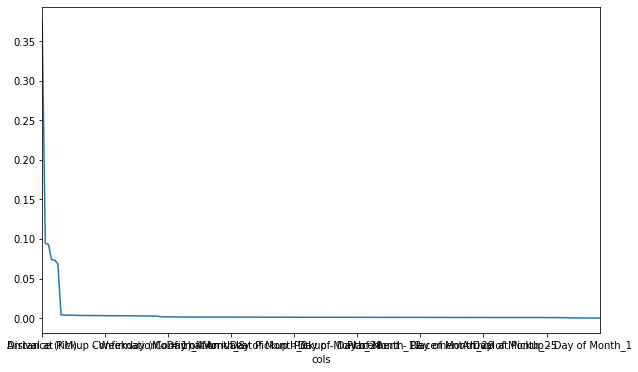

In [53]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [161]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [11]:
x.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival', 'No_Of_Orders', 'Age', 'Average_Rating',
       'No_of_Ratings'],
      dtype='object')

In [ ]:
rel_feat = ['Distance (KM)','Destination Long','Destination Lat','Pickup Lat', 'Pickup Long','Pickup time','Temperature']

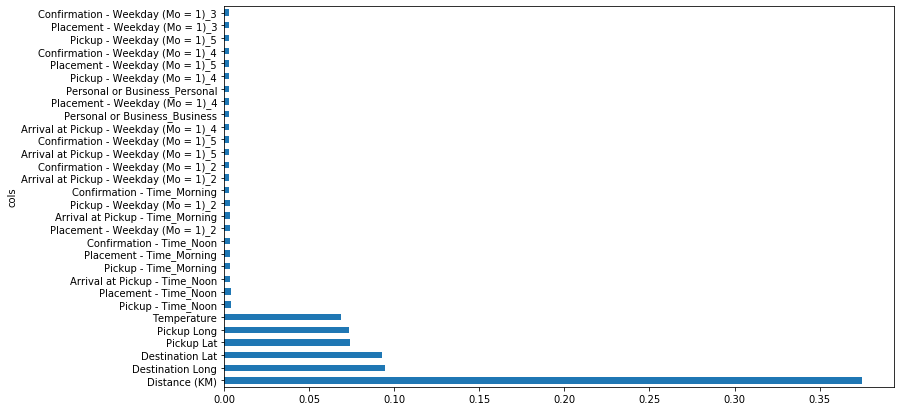

In [59]:
plot_fi(fi[:30]);

#### XGBOOST

In [63]:
import xgboost 

In [82]:
xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.09, gamma=0, subsample=0.5,
                           colsample_bytree=1, max_depth=7)

In [83]:
xgb.fit(X_train,y_train)

/Users/socrates/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:32:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.09, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=1)

In [84]:
print_score(xgb)

[586.1097490588558, 831.7712881230683, 0.646379746035527, 0.3318397030562984]


In [85]:
y = xgb.predict(df_test.drop("Order No",axis=1))

In [86]:
y

array([1527.0703, 1228.0945, 1168.4033, ..., 1463.0334, 2850.5103,
       2101.073 ], dtype=float32)

In [87]:
submission = df_sample_submission.copy()

In [88]:
submission["Time from Pickup to Arrival"] = y

In [89]:
submission = submission.set_index('Order_No')

In [90]:
submission.to_csv('submission_xgb.csv')

In [93]:
xgb.get_booster().get_score(importance_type="gain")

{'Distance (KM)': 16527635.78130719,
 'Destination Long': 2169926.536926603,
 'Temperature': 1922496.519928159,
 'Arrival at Pickup - Day of Month_9': 2036861.5693552631,
 'Destination Lat': 1888660.6449150054,
 'Pickup Lat': 2333949.0609059674,
 'Arrival at Pickup - Day of Month_2': 2271802.279282759,
 'Pickup Long': 2364764.9801419913,
 'Arrival at Pickup - Day of Month_10': 1740901.2862354433,
 'Platform Type_1': 1891895.2863517855,
 'Arrival at Pickup - Day of Month_22': 1682944.5281417912,
 'Platform Type_3': 1965846.7116166665,
 'Arrival at Pickup - Day of Month_30': 2404475.0744121494,
 'Arrival at Pickup - Weekday (Mo = 1)_2': 2103237.7397648804,
 'Personal or Business_Business': 1819000.7074840001,
 'Arrival at Pickup - Day of Month_15': 2328060.518561797,
 'Arrival at Pickup - Day of Month_31': 1726036.6419866667,
 'Arrival at Pickup - Weekday (Mo = 1)_1': 2335180.9789506844,
 'Platform Type_4': 1716478.9849999999,
 'Arrival at Pickup - Day of Month_8': 2336441.6984633664,
 '

### NEW

In [85]:
df_rf = df.copy()

In [74]:
rel_feat = ['Distance (KM)','Destination Long','Destination Lat','Pickup Lat', 'Pickup Long','Pickup - Time','Temperature','col_type','Time from Pickup to Arrival']

In [86]:
df_rf = df_rf[rel_feat]

In [88]:
df_rf.columns

Index(['Distance (KM)', 'Destination Long', 'Destination Lat', 'Pickup Lat',
       'Pickup Long', 'Pickup - Time', 'Temperature', 'col_type',
       'Time from Pickup to Arrival'],
      dtype='object')

In [89]:
df_rf.dtypes

Distance (KM)                    int64
Destination Long               float64
Destination Lat                float64
Pickup Lat                     float64
Pickup Long                    float64
Pickup - Time                   object
Temperature                    float64
col_type                        object
Time from Pickup to Arrival    float64
dtype: object

In [90]:
df_rf['Pickup - Time'] = pd.to_datetime(df_rf['Pickup - Time'])

/Users/socrates/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [91]:
df_rf.dtypes

Distance (KM)                           int64
Destination Long                      float64
Destination Lat                       float64
Pickup Lat                            float64
Pickup Long                           float64
Pickup - Time                  datetime64[ns]
Temperature                           float64
col_type                               object
Time from Pickup to Arrival           float64
dtype: object

In [92]:
df_rf['Pickup - Time'] = df_rf['Pickup - Time'].apply(lambda x: x.hour)

/Users/socrates/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [93]:
df_rf['Pickup - Time'] = df_rf['Pickup - Time'].apply(f)

/Users/socrates/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [94]:
df_rf = pd.get_dummies(data=df_rf, columns=['Pickup - Time'])

In [95]:
df_rf.columns

Index(['Distance (KM)', 'Destination Long', 'Destination Lat', 'Pickup Lat',
       'Pickup Long', 'Temperature', 'col_type', 'Time from Pickup to Arrival',
       'Pickup - Time_Eve', 'Pickup - Time_Morning', 'Pickup - Time_Noon'],
      dtype='object')

In [96]:
df_rf['Temperature'] = df_rf['Temperature'].fillna(df_rf['Temperature'].mean())

In [97]:
df_rf.isna().sum()

Distance (KM)                     0
Destination Long                  0
Destination Lat                   0
Pickup Lat                        0
Pickup Long                       0
Temperature                       0
col_type                          0
Time from Pickup to Arrival    7068
Pickup - Time_Eve                 0
Pickup - Time_Morning             0
Pickup - Time_Noon                0
dtype: int64

In [57]:
train = df_rf[df_rf['col_type'] == 'train'].drop(['col_type'],axis=1)
test = df_rf[df_rf['col_type'] == 'test'].drop(['col_type',"Time from Pickup to Arrival"],axis=1)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop("Time from Pickup to Arrival",axis=1), train['Time from Pickup to Arrival'], test_size=0.05, random_state=42)

In [99]:
from sklearn.ensemble import RandomForestRegressor

In [123]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=2, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[485.08175941586194, 838.4574115993895, 0.757780485461041, 0.32105462852962297, 0.3346913691549285]


In [160]:
fi = rf_feat_importance(m,X_train);fi[:]

,cols,imp
0,Distance (KM),0.387286
2,Destination Lat,0.129442
1,Destination Long,0.129184
5,Temperature,0.124282
3,Pickup Lat,0.103531
4,Pickup Long,0.100208
8,Pickup - Time_Noon,0.013001
7,Pickup - Time_Morning,0.012514
6,Pickup - Time_Eve,0.000551


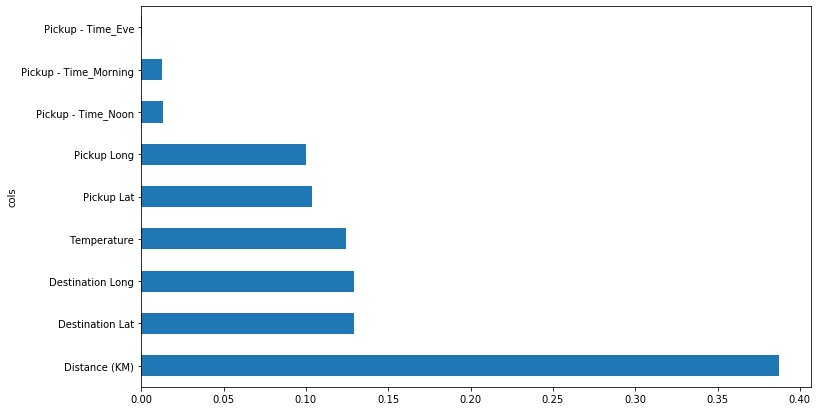

In [162]:
plot_fi(fi[:30])

In [171]:
import scipy

In [172]:
from scipy.cluster import hierarchy as hc

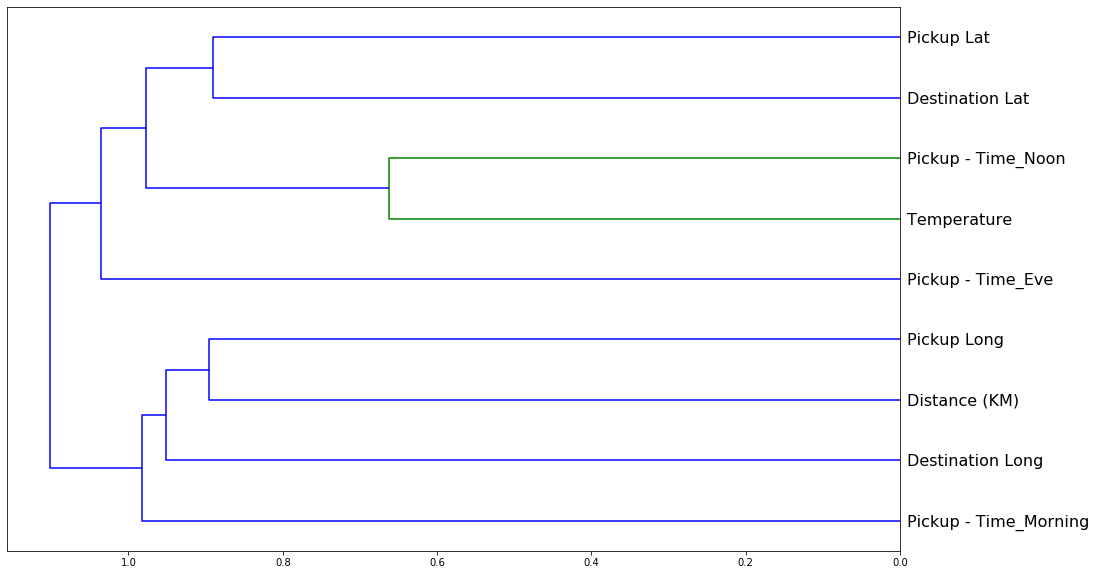

In [174]:
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

In [124]:
y = m.predict(test)

In [125]:
submission = df_sample_submission.copy()

In [126]:
submission["Time from Pickup to Arrival"] = y
submission = submission.set_index('Order_No')
submission.to_csv('rf.csv')

#### xgboost

In [137]:
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=50, learning_rate=0.09, gamma=0, subsample=0.5,
                           colsample_bytree=1, max_depth=7)

In [138]:
xgb.fit(X_train,y_train)
print_score(xgb)

/Users/socrates/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:59:11] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[709.0256520313436, 830.272596621326, 0.4825085997637185, 0.33424532594503165]


In [129]:
y = xgb.predict(test)

In [130]:
submission = df_sample_submission.copy()

In [131]:
submission = df_sample_submission.copy()
submission["Time from Pickup to Arrival"] = y
submission = submission.set_index('Order_No')
submission.to_csv('xgb.csv')

#### LightGBM

In [132]:
import lightgbm as lgb

/Users/socrates/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [154]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.09,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 1,
    "max_depth": 6,
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

In [155]:
gbm = lgb.LGBMRegressor(**hyper_params)

In [156]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=100)

[1]	valid_0's l1: 737.771	valid_0's rmse: 989.115
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l1: 713.388	valid_0's rmse: 964.968
[3]	valid_0's l1: 691.625	valid_0's rmse: 944.042
[4]	valid_0's l1: 672.431	valid_0's rmse: 926.813
[5]	valid_0's l1: 656.334	valid_0's rmse: 912.234
[6]	valid_0's l1: 642.366	valid_0's rmse: 899.479
[7]	valid_0's l1: 630.046	valid_0's rmse: 888.606
[8]	valid_0's l1: 619.303	valid_0's rmse: 879.584
[9]	valid_0's l1: 609.916	valid_0's rmse: 871.525
[10]	valid_0's l1: 602.3	valid_0's rmse: 864.951
[11]	valid_0's l1: 594.609	valid_0's rmse: 858.575
[12]	valid_0's l1: 588.329	valid_0's rmse: 853.802
[13]	valid_0's l1: 582.844	valid_0's rmse: 849.969
[14]	valid_0's l1: 577.895	valid_0's rmse: 846.38
[15]	valid_0's l1: 573.631	valid_0's rmse: 843.436
[16]	valid_0's l1: 570.403	valid_0's rmse: 841.041
[17]	valid_0's l1: 567.069	valid_0's rmse: 838.679
[18]	valid_0's l1: 564.617	valid_0's rmse: 837.355
[19]	valid_0's l1: 562.488	vali

[203]	valid_0's l1: 541.719	valid_0's rmse: 826.79
[204]	valid_0's l1: 541.544	valid_0's rmse: 826.879
Early stopping, best iteration is:
[104]	valid_0's l1: 538.789	valid_0's rmse: 822.397


LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.09, max_bin=512,
              max_depth=6, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
              n_jobs=-1, num_iterations=100000, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, task='train',
              verbose=1)

In [157]:
print_score(gbm)

[730.1614162105948, 822.3969529757484, 0.45119633764477096, 0.3468156044014733]


In [158]:
y = gbm.predict(test)

In [159]:
submission = df_sample_submission.copy()
submission["Time from Pickup to Arrival"] = y
submission = submission.set_index('Order_No')
submission.to_csv('gbm.csv')

In [163]:
df_variable_definitions

,Order No,Unique number identifying the order
0,User Id,Unique number identifying the customer on a pl...
1,Vehicle Type,"For this competition limited to bikes, however..."
2,Platform Type,"Platform used to place the order, there are 4 ..."
3,Personal or Business,Customer type
4,Placement - Day of Month,Placement - Day of Month i.e 1-31
5,Placement - Weekday (Mo = 1),Placement - Weekday (Monday = 1)
6,Placement - Time,Placement - Time - Time of day the order was p...
7,Confirmation - Day of Month,Confirmation - Day of Month i.e 1-31
8,Confirmation - Weekday (Mo = 1),Confirmation - Weekday (Monday = 1)
9,Confirmation - Time,Confirmation - Time - Time of day the order wa...


In [164]:
df_riders

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156
...,...,...,...,...,...
955,Rider_Id_896,152,99,12.4,18
956,Rider_Id_149,69,101,10.2,10
957,Rider_Id_270,338,96,14.4,41
958,Rider_Id_201,159,96,15.0,9


In [166]:
df_train.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival'],
      dtype='object')

In [168]:
df_train.T

,0,1,2,3,4,5,6,7,8,9,...,21191,21192,21193,21194,21195,21196,21197,21198,21199,21200
Order No,Order_No_4211,Order_No_25375,Order_No_1899,Order_No_9336,Order_No_27883,Order_No_7408,Order_No_22680,Order_No_21578,Order_No_5234,Order_No_1768,...,Order_No_16262,Order_No_11670,Order_No_4988,Order_No_865,Order_No_9932,Order_No_8834,Order_No_22892,Order_No_2831,Order_No_6174,Order_No_9836
User Id,User_Id_633,User_Id_2285,User_Id_265,User_Id_1402,User_Id_1737,User_Id_1342,User_Id_2803,User_Id_1075,User_Id_733,User_Id_2112,...,User_Id_1231,User_Id_1146,User_Id_875,User_Id_1245,User_Id_3582,User_Id_2001,User_Id_1796,User_Id_2956,User_Id_2524,User_Id_718
Vehicle Type,Bike,Bike,Bike,Bike,Bike,Bike,Bike,Bike,Bike,Bike,...,Bike,Bike,Bike,Bike,Bike,Bike,Bike,Bike,Bike,Bike
Platform Type,3,3,3,3,1,3,3,3,3,3,...,3,3,1,3,3,3,3,3,1,3
Personal or Business,Business,Personal,Business,Business,Personal,Business,Business,Business,Business,Business,...,Business,Business,Personal,Business,Business,Personal,Business,Business,Personal,Business
Placement - Day of Month,9,12,30,15,13,14,9,11,30,23,...,1,23,12,15,2,20,13,7,4,26
Placement - Weekday (Mo = 1),5,5,2,5,1,5,5,1,2,5,...,4,2,6,1,6,3,6,4,3,2
Placement - Time,9:35:46 AM,11:16:16 AM,12:39:25 PM,9:25:34 AM,9:55:18 AM,3:07:35 PM,9:33:45 AM,2:13:01 PM,11:10:44 AM,4:48:54 PM,...,2:09:37 PM,12:41:17 PM,4:48:16 PM,5:02:09 PM,1:08:34 PM,3:54:38 PM,10:13:34 AM,5:06:16 PM,9:31:39 AM,2:19:47 PM
Confirmation - Day of Month,9,12,30,15,13,14,9,11,30,23,...,1,23,12,15,2,20,13,7,4,26
Confirmation - Weekday (Mo = 1),5,5,2,5,1,5,5,1,2,5,...,4,2,6,1,6,3,6,4,3,2


### New features 